<a href="https://colab.research.google.com/github/Jules-gatete/Assignment-1--Time-Series-Forecasting-/blob/main/Assignment_1_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install optuna

# Import Libraries
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import optuna
import os

In [50]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# **1. Data Loading and Preprocessing**

In [51]:
# Load datasets
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Convert datetime
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

# Handle missing values
train_df = train_df.dropna(subset=['pm2.5']).interpolate(method='linear')
test_df = test_df.interpolate(method='linear')

In [52]:
print(train_df.columns)

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')


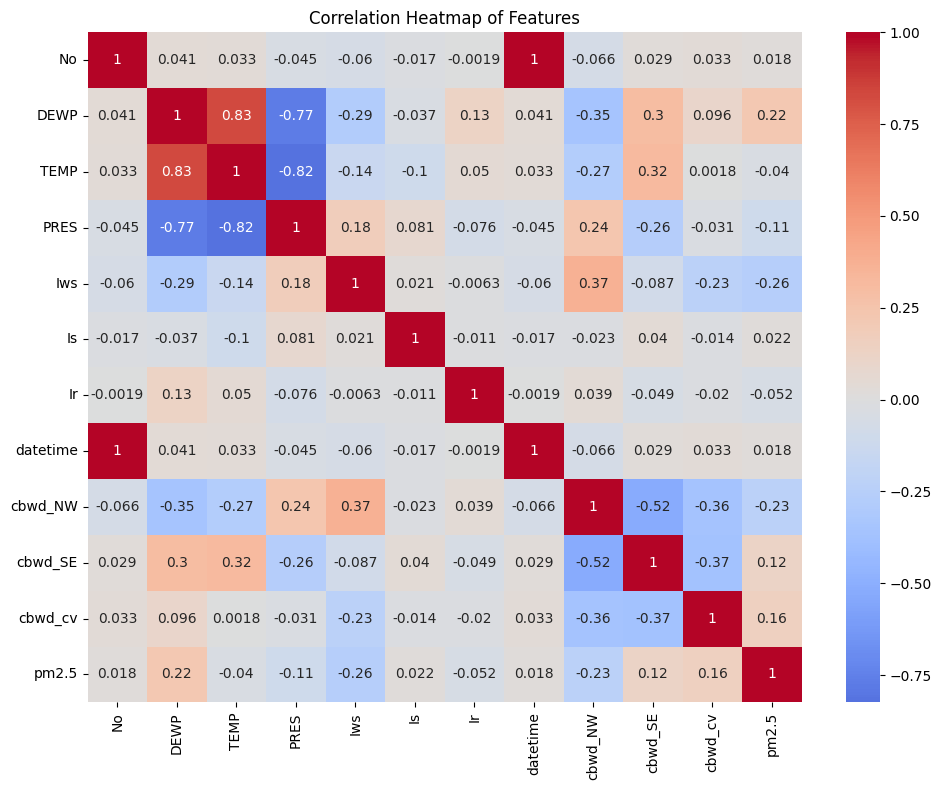

In [53]:
# Added: Correlation Heatmap to visualize feature relationships
plt.figure(figsize=(10, 8))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

In [54]:
# Create sequences with stride
def create_sequences(data, target, seq_length, stride=1):
    X, y = [], []
    for i in range(0, len(data) - seq_length, stride):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)


In [55]:
# Feature engineering: Extract temporal features from datetime
train_df['hour'] = train_df['datetime'].dt.hour
train_df['day'] = train_df['datetime'].dt.day
train_df['month'] = train_df['datetime'].dt.month
train_df['dayofweek'] = train_df['datetime'].dt.dayofweek

test_df['hour'] = test_df['datetime'].dt.hour
test_df['day'] = test_df['datetime'].dt.day
test_df['month'] = test_df['datetime'].dt.month
test_df['dayofweek'] = test_df['datetime'].dt.dayofweek

# Define feature columns (adjust based on your dataset)
feature_columns = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv',
                   'hour', 'day', 'month', 'dayofweek']

# Scale features and target
scaler_features = MinMaxScaler()
scaler_pm25 = MinMaxScaler()

# Fit and transform features
train_df[feature_columns] = scaler_features.fit_transform(train_df[feature_columns])
test_df[feature_columns] = scaler_features.transform(test_df[feature_columns])

# Fit and transform target (pm2.5)
train_df['pm2.5_scaled'] = scaler_pm25.fit_transform(train_df[['pm2.5']])

# **2. Model Definition**


In [56]:
def build_model(seq_length, n_features, units, layers, dropout, learning_rate):
    model = Sequential()
    if layers == 1:
        model.add(LSTM(units, activation='relu', input_shape=(seq_length, n_features)))
        model.add(Dropout(dropout))
    else:
        model.add(LSTM(units, activation='relu', input_shape=(seq_length, n_features), return_sequences=True))
        model.add(Dropout(dropout))
        for _ in range(layers - 2):
            model.add(LSTM(units // 2, activation='relu', return_sequences=True))
            model.add(Dropout(dropout))
        model.add(LSTM(units // 2, activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, dtype='float32'))  # Ensure output is float32 for mixed precision
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


In [57]:
def compute_feature_importance(model, X, y, feature_names):
    """Compute feature importance using permutation importance."""
    results = permutation_importance(model, X, y, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
    importance = pd.DataFrame({'Feature': feature_names, 'Importance': results.importances_mean})
    importance = importance.sort_values('Importance', ascending=False)
    return importance

# **3. Hyperparameter Optimization with Optuna**


In [58]:
def objective(trial):
    params = {
        'seq_length': trial.suggest_int('seq_length', 12, 48, step=12),
        'units': trial.suggest_int('units', 32, 128, step=32),
        'layers': trial.suggest_int('layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.1, 0.4, step=0.1),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'stride': trial.suggest_int('stride', 1, 3)
    }

    X_train, y_train = create_sequences(
        train_df[feature_columns].values,
        train_df['pm2.5_scaled'].values,
        params['seq_length'],
        params['stride']
    )

    model = build_model(
        params['seq_length'],
        len(feature_columns),
        params['units'],
        params['layers'],
        params['dropout'],
        params['lr']
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=30,  # Reduced epochs for faster training
        batch_size=params['batch_size'],
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=0
    )

    val_predictions = model.predict(X_train[-int(0.2 * len(X_train)):], verbose=0)
    val_true = y_train[-int(0.2 * len(X_train)):]
    val_predictions = scaler_pm25.inverse_transform(val_predictions)
    val_true = scaler_pm25.inverse_transform(val_true.reshape(-1, 1))
    rmse = np.sqrt(np.mean((val_true - val_predictions) ** 2))
    return rmse

In [72]:
# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {study.best_value:.2f}")

[I 2025-05-27 21:54:52,555] A new study created in memory with name: no-name-8e29c77c-c165-43ac-85e5-c3c13239671f
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-05-27 22:00:13,618] Trial 0 finished with value: 78.84255609706528 and parameters: {'seq_length': 36, 'units': 128, 'layers': 1, 'dropout': 0.1, 'lr': 0.0011255344204967497, 'batch_size': 16, 'stride': 2}. Best is trial 0 with value: 78.84255609706528.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-05-27 22:07:13,245] Trial 1 finished with val

Best Parameters: {'seq_length': 12, 'units': 96, 'layers': 1, 'dropout': 0.2, 'lr': 0.002776558748081427, 'batch_size': 16, 'stride': 3}
Best RMSE: 76.12


# **4. Iterative Prediction for Test Set**


In [73]:
def iterative_predict(model, train_data, test_data, seq_length, feature_columns, scaler_pm25):
    predictions = []
    last_sequence = train_data[feature_columns].values[-seq_length:].copy()
    last_pm25 = train_data['pm2.5_scaled'].values[-seq_length:].reshape(-1, 1)

    for i in range(len(test_data)):
        # Prepare input sequence
        X = np.array([last_sequence])
        pred_scaled = model.predict(X, verbose=0)
        pred = scaler_pm25.inverse_transform(pred_scaled)[0, 0]
        predictions.append(pred)

        # Update sequence with test data and predicted PM2.5
        next_row = test_data[feature_columns].iloc[i].values
        last_sequence = np.vstack([last_sequence[1:], next_row])
        last_pm25 = np.vstack([last_pm25[1:], pred_scaled])

    return np.array(predictions)

In [74]:
# Train final model with best parameters
X_train, y_train = create_sequences(
    train_df[feature_columns].values,
    train_df['pm2.5_scaled'].values,
    best_params['seq_length'],
    best_params['stride']
)

final_model = build_model(
    best_params['seq_length'],
    len(feature_columns),
    best_params['units'],
    best_params['layers'],
    best_params['dropout'],
    best_params['lr']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Assign the history object returned by fit() to a variable
final_history = final_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=best_params['batch_size'],
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


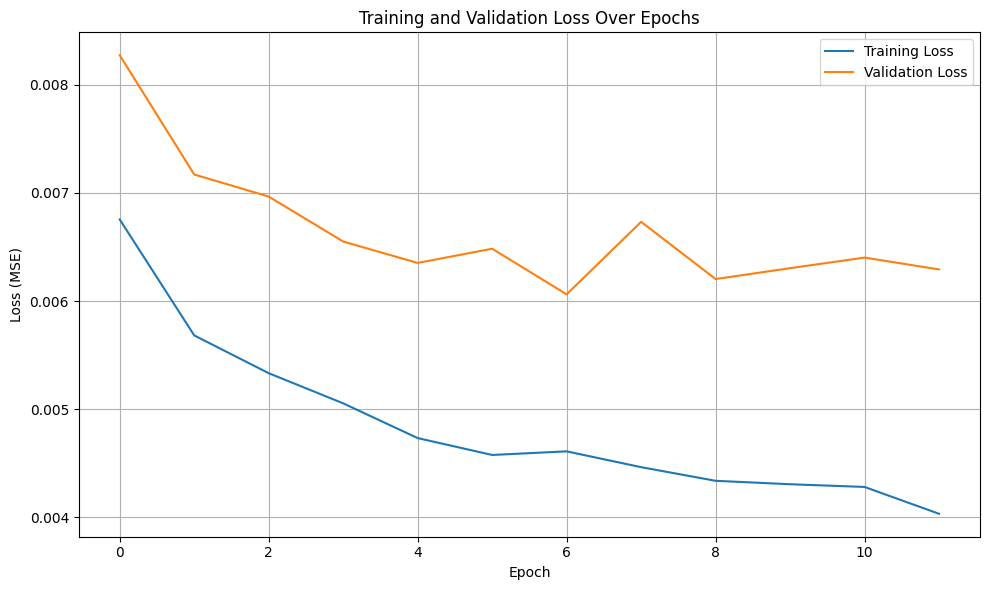

In [75]:
# Added: Plot training history
plt.figure(figsize=(10, 6))
# Use the captured history object from the final model training
plt.plot(final_history.history['loss'], label='Training Loss', color='#1f77b4')
plt.plot(final_history.history['val_loss'], label='Validation Loss', color='#ff7f0e')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
# Added: Compute additional performance metrics
val_predictions = final_model.predict(X_train[-100:], verbose=0)
val_true = y_train[-100:]
val_predictions = scaler_pm25.inverse_transform(val_predictions)
val_true = scaler_pm25.inverse_transform(val_true.reshape(-1, 1))
rmse = np.sqrt(np.mean((val_true - val_predictions) ** 2))
mae = mean_absolute_error(val_true, val_predictions)
r2 = r2_score(val_true, val_predictions)

In [77]:
# Added: Display performance metrics
print("\nValidation Performance Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Validation Performance Metrics:
RMSE: 67.09
MAE: 45.18
R² Score: 0.27


In [78]:
# Iterative prediction for test set
def iterative_predict(model, train_data, test_data, seq_length, feature_columns, scaler_pm25):
    """Generate iterative predictions for test set."""
    predictions = []
    last_sequence = train_data[feature_columns].values[-seq_length:].copy()
    last_pm25 = train_data['pm2.5_scaled'].values[-seq_length:].reshape(-1, 1)

    for i in range(len(test_data)):
        X = np.array([last_sequence])
        pred_scaled = model.predict(X, verbose=0)
        pred = scaler_pm25.inverse_transform(pred_scaled)[0, 0]
        predictions.append(pred)
        next_row = test_data[feature_columns].iloc[i].values
        last_sequence = np.vstack([last_sequence[1:], next_row])
        last_pm25 = np.vstack([last_pm25[1:], pred_scaled])

    return np.array(predictions)

In [80]:
# Generate predictions
predictions = iterative_predict(final_model, train_df, test_df, best_params['seq_length'], feature_columns, scaler_pm25)

# Create submission
final_submission = pd.DataFrame({
    'row ID': test_df['datetime'].dt.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions
})
final_submission.to_csv('/content/submissionfin.csv', index=False)
print("Final submission saved as 'submissionfin.csv'")

Final submission saved as 'submissionfin.csv'


In [87]:
final_submission.to_csv('/content/submissionfin.csv', index=False)
print("Final submission saved as 'submissionfin.csv'")

Final submission saved as 'submissionfin.csv'


In [83]:
# Validation predictions for best model
val_predictions = final_model.predict(X_train[-100:], verbose=0)
val_true = y_train[-100:]
val_predictions = scaler_pm25.inverse_transform(val_predictions)
val_true = scaler_pm25.inverse_transform(val_true.reshape(-1, 1))

# **Visualization**

In [84]:
# Create a line chart for actual vs predicted PM2.5
chart_data = {
    "type": "line",
    "data": {
        "labels": list(range(100)),
        "datasets": [
            {
                "label": "Actual PM2.5",
                "data": val_true.flatten().tolist(),
                "borderColor": "#1f77b4",
                "fill": False
            },
            {
                "label": "Predicted PM2.5",
                "data": val_predictions.flatten().tolist(),
                "borderColor": "#ff7f0e",
                "fill": False
            }
        ]
    },
    "options": {
        "title": {
            "display": True,
            "text": "Best Model: Actual vs Predicted PM2.5"
        },
        "scales": {
            "x": {
                "title": {
                    "display": True,
                    "text": "Sample"
                }
            },
            "y": {
                "title": {
                    "display": True,
                    "text": "PM2.5 (µg/m³)"
                }
            }
        }
    }
}